In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from fractions import Fraction
from sklearn.model_selection import train_test_split

folders = tf.io.gfile.glob(str('data/train/*/*'))
folders.extend(tf.io.gfile.glob(str('data/val/*/*')))
train, validate = train_test_split(folders, test_size=0.2)
train_data = tf.data.Dataset.from_tensor_slices(train)
val_data = tf.data.Dataset.from_tensor_slices(validate)

In [4]:
NORMAL = len([folder for folder in train if "normal" in folder])
PNEUMONIA = len([folder for folder in train if "opacity" in folder])
TRAINING_NUM = (NORMAL + PNEUMONIA)
print("Number of training images: " + str(TRAINING_NUM))

VALIDATING_NUM = tf.data.experimental.cardinality(val_data).numpy()
print("Validating images count: " + str(VALIDATING_NUM))

print("Quotient of training images to validating images: " + str(Fraction(TRAINING_NUM / VALIDATING_NUM).limit_denominator(1)))

Number of training images: 4108
Validating images count: 1028
Quotient of training images to validating images: 4


This means that the ratio for our image data is around 80:20 which is where we want it

In [5]:
FOLDERNAME = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str('data/train/*'))]) 
FOLDERNAME

def get_name(file_path):
    arr = tf.strings.split(file_path, os.path.sep)
    return arr[-2] == "opacity"

Now we are going to convert the images into 256x256 uint8 tensor. Also, since we are working with jpegs, we can use tensorflows dtype to convert its integer range that can go up to 255, down to a floating point max of 1.


In [6]:
DIMENSIONS = [256, 256]

def convert_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float64)
    return tf.image.resize(img, DIMENSIONS)

In [7]:
def access(file):
    label = get_name(file)
    img = tf.io.read_file(file)
    img = convert_img(img)
    return img, label

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train = train_data.map(access, num_parallel_calls=AUTOTUNE)
val = val_data.map(access, num_parallel_calls=AUTOTUNE)

In [9]:
BATCH_SIZE = 32
testdata = tf.data.Dataset.list_files(str('data/test/*/*'))
TESTING_NUM = tf.data.experimental.cardinality(testdata).numpy()
test_data = testdata.map(access, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE)
TESTING_NUM

624

In [10]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [11]:
train = prepare_for_training(train)
val = prepare_for_training(val)
image_batch, labeled_batch = next(iter(train))

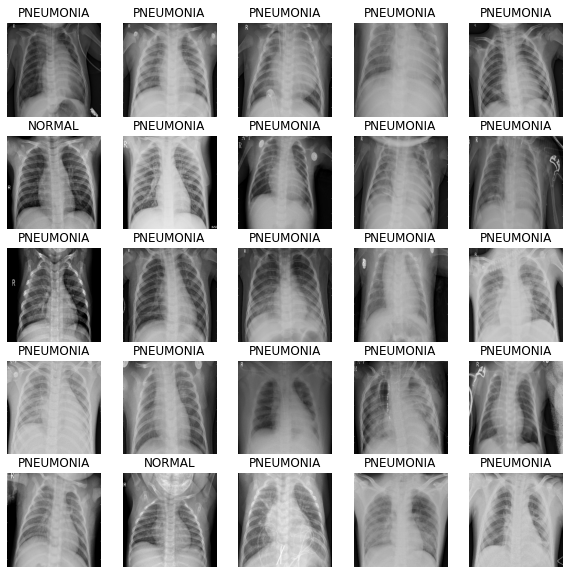

In [12]:
def show_batch(image_batch, labeled_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if labeled_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

In [13]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    return block

In [14]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [15]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(DIMENSIONS[0], DIMENSIONS[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [16]:
EPOCHS = 200
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=EPOCHS)
callbacks = [early_stop_callback]
weight0 = (1 / NORMAL)*(TRAINING_NUM)/2.0 
weight1 = (1 / PNEUMONIA)*(TRAINING_NUM)/2.0
class_weight = {0: weight0, 1: weight1}

In [17]:
strategy = tf.distribute.get_strategy()
with strategy.scope():
    model = build_model()
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [18]:
history = model.fit(
    train,
    steps_per_epoch = TRAINING_NUM // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data = val,
    validation_steps = VALIDATING_NUM // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 1/200


KeyboardInterrupt: 